In [2]:
!wget https://polybox.ethz.ch/index.php/s/6AqsZwoQG8l6rAu/download

--2020-12-16 10:43:50--  https://polybox.ethz.ch/index.php/s/6AqsZwoQG8l6rAu/download
Resolving polybox.ethz.ch (polybox.ethz.ch)... 129.132.71.243
Connecting to polybox.ethz.ch (polybox.ethz.ch)|129.132.71.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 239750049 (229M) [application/zip]
Saving to: ‘download’

download            100%[===================>] 228.64M  19.3MB/s    in 13s     

2020-12-16 10:44:04 (18.0 MB/s) - ‘download’ saved [239750049/239750049]



In [3]:
!unzip download

Streaming output truncated to the last 5000 lines.
 extracting: single-cell-sample/Week4_27481-B06-s4+41@1031x207.png  
 extracting: single-cell-sample/Week10_40111-D06-s4+18@1146x419.png  
 extracting: single-cell-sample/Week3_25421-D06-s1+11@314x723.png  
 extracting: single-cell-sample/Week10_40111-D04-s2+19@947x389.png  
 extracting: single-cell-sample/Week7_34641-C04-s3+62@1089x674.png  
 extracting: single-cell-sample/Week7_34681-E06-s1+43@380x209.png  
 extracting: single-cell-sample/Week8_38341-E04-s1+37@605x867.png  
 extracting: single-cell-sample/Week3_25681-C06-s2+65@916x707.png  
 extracting: single-cell-sample/Week3_25421-D08-s2+9@557x938.png  
 extracting: single-cell-sample/Week7_34681-G05-s3+40@1221x593.png  
 extracting: single-cell-sample/Week3_25461-D04-s4+13@476x826.png  
 extracting: single-cell-sample/Week1_22123-E04-s2+87@1195x865.png  
 extracting: single-cell-sample/Week4_27861-B05-s3+51@483x734.png  
  inflating: single-cell-sample/Week1_22401-E07-s1+49@1093x

In [5]:
import tensorflow as tf
print(tf.__version__)

physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import matplotlib.pyplot as plt
from imutils import paths
from tqdm import tqdm
import tensorflow as tf
import numpy as np
import cv2

# Random seed fixation
tf.random.set_seed(666)
np.random.seed(666)

train_images = list(paths.list_images("single-cell-sample/"))
print(len(train_images))

# Augmentation utilities (differs from the original implementation)
# Referred from: https://arxiv.org/pdf/2002.05709.pdf (Appendxi A
# corresponding GitHub: https://github.com/google-research/simclr/)

class CustomAugment(object):
    def __call__(self, sample):
        # Random flips
        sample = self._random_apply(tf.image.flip_left_right, sample, p=0.5)

        # Randomly apply transformation (color distortions) with probability p.
        sample = self._random_apply(self._color_jitter, sample, p=0.8)
        sample = self._random_apply(self._color_drop, sample, p=0.2)

        return sample

    def _color_jitter(self, x, s=1):
        # one can also shuffle the order of following augmentations
        # each time they are applied.
        x = tf.image.random_brightness(x, max_delta=0.8*s)
        x = tf.image.random_contrast(x, lower=1-0.8*s, upper=1+0.8*s)
        x = tf.image.random_saturation(x, lower=1-0.8*s, upper=1+0.8*s)
        x = tf.image.random_hue(x, max_delta=0.2*s)
        x = tf.clip_by_value(x, 0, 1)
        return x

    def _color_drop(self, x):
        x = tf.image.rgb_to_grayscale(x)
        x = tf.tile(x, [1, 1, 1, 3])
        return x

    def _random_apply(self, func, x, p):
        return tf.cond(
          tf.less(tf.random.uniform([], minval=0, maxval=1, dtype=tf.float32),
                  tf.cast(p, tf.float32)),
          lambda: func(x),
          lambda: x)

# Build the augmentation pipeline
data_augmentation = Sequential([Lambda(CustomAugment())])

@tf.function
def parse_cell_images(image_path):
    image_string = tf.io.read_file(image_path)
    image = tf.image.decode_png(image_string, channels=1)
    image = tf.squeeze(image)
    image = tf.split(image, 3, axis=1)
    image = tf.transpose(image, [1,2,0])
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, size=[224, 224])

    return image

2.3.0
Num GPUs: 1
18694


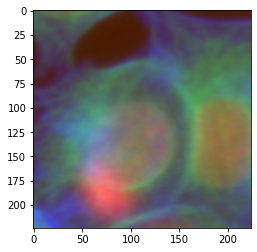

In [7]:
# check channels
im = parse_cell_images(train_images[0])
imgplot = plt.imshow(im)
plt.show()

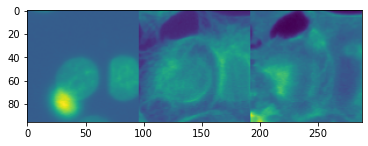

In [8]:
import matplotlib.image as mpimg
img = mpimg.imread(train_images[0])
imgplot = plt.imshow(img)
plt.show()

In [10]:
BATCH_SIZE = 64

train_ds = tf.data.Dataset.from_tensor_slices(train_images)
train_ds = (
    train_ds
    .map(parse_cell_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .shuffle(1024)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

# Architecture utils
def get_resnet_simclr(hidden_1, hidden_2, hidden_3):
    base_model = tf.keras.applications.ResNet50(include_top=False, weights=None, input_shape=(224, 224, 3))
    base_model.trainable = True
    inputs = Input((224, 224, 3))
    h = base_model(inputs, training=True)
    h = GlobalAveragePooling2D()(h)

    projection_1 = Dense(hidden_1)(h)
    projection_1 = Activation("relu")(projection_1)
    projection_2 = Dense(hidden_2)(projection_1)
    projection_2 = Activation("relu")(projection_2)
    projection_3 = Dense(hidden_3)(projection_2)

    resnet_simclr = Model(inputs, projection_3)

    return resnet_simclr

In [11]:

from losses import _dot_simililarity_dim1 as sim_func_dim1, _dot_simililarity_dim2 as sim_func_dim2
import helpers

# Mask to remove positive examples from the batch of negative samples
negative_mask = helpers.get_negative_mask(BATCH_SIZE)

@tf.function
def train_step(xis, xjs, model, optimizer, criterion, temperature):
    with tf.GradientTape() as tape:
        zis = model(xis)
        zjs = model(xjs)

        # normalize projection feature vectors
        zis = tf.math.l2_normalize(zis, axis=1)
        zjs = tf.math.l2_normalize(zjs, axis=1)

        l_pos = sim_func_dim1(zis, zjs)
        l_pos = tf.reshape(l_pos, (BATCH_SIZE, 1))
        l_pos /= temperature

        negatives = tf.concat([zjs, zis], axis=0)

        loss = 0

        for positives in [zis, zjs]:
            l_neg = sim_func_dim2(positives, negatives)

            labels = tf.zeros(BATCH_SIZE, dtype=tf.int32)

            l_neg = tf.boolean_mask(l_neg, negative_mask)
            l_neg = tf.reshape(l_neg, (BATCH_SIZE, -1))
            l_neg /= temperature

            logits = tf.concat([l_pos, l_neg], axis=1)
            loss += criterion(y_pred=logits, y_true=labels)

        loss = loss / (2 * BATCH_SIZE)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss

def train_simclr(model, dataset, optimizer, criterion,
                 temperature=0.1, epochs=100):
    step_wise_loss = []
    epoch_wise_loss = []

    for epoch in tqdm(range(epochs)):
        for image_batch in dataset:
            a = data_augmentation(image_batch)
            b = data_augmentation(image_batch)

            loss = train_step(a, b, model, optimizer, criterion, temperature)
            step_wise_loss.append(loss)

        epoch_wise_loss.append(np.mean(step_wise_loss))
        #wandb.log({"nt_xentloss": np.mean(step_wise_loss)})

        if epoch % 10 == 0:
            print("epoch: {} loss: {:.3f}".format(epoch + 1, np.mean(step_wise_loss)))

    return epoch_wise_loss, model


In [ ]:
criterion = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                          reduction=tf.keras.losses.Reduction.SUM)
decay_steps = 1000
lr_decayed_fn = tf.keras.experimental.CosineDecay(
    initial_learning_rate=0.1, decay_steps=decay_steps)
optimizer = tf.keras.optimizers.SGD(lr_decayed_fn)

resnet_simclr_2 = get_resnet_simclr(256, 128, 50)

epoch_wise_loss, resnet_simclr  = train_simclr(resnet_simclr_2, train_ds, optimizer, criterion,
                 temperature=0.1, epochs=200)

  0%|          | 1/200 [06:25<21:19:32, 385.79s/it]

epoch: 1 loss: 3.768


  6%|▌         | 11/200 [1:08:41<19:37:28, 373.80s/it]

epoch: 11 loss: 2.568


 10%|█         | 21/200 [2:10:57<18:34:46, 373.67s/it]

epoch: 21 loss: 2.456


 16%|█▌        | 31/200 [3:13:12<17:32:08, 373.54s/it]

epoch: 31 loss: 2.436


 20%|██        | 41/200 [4:15:31<16:30:28, 373.76s/it]

epoch: 41 loss: 2.430


 24%|██▎       | 47/200 [4:52:53<15:52:58, 373.71s/it]

KeyboardInterrupt: ignored

In [ ]:
import datetime
filename = datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "resnet_simclr.h5"
resnet_simclr_2.save_weights(filename)


In [ ]:
with plt.xkcd():
    plt.plot(epoch_wise_loss)
    plt.title("tau = 0.1, h1 = 256, h2 = 128, h3 = 50")
    plt.show()

In [ ]:
#tSNE

In [ ]:
import pandas as pd
dataframe = pd.read_csv("single-cell-sample/sc-metadata.csv")

labels = dataframe['Target']
images = dataframe['Image_Name']

In [ ]:
@tf.function
def parse_cell_images2(image_path):
    image_string = tf.io.read_file("single-cell-sample/"+image_path)
    image = tf.image.decode_png(image_string, channels=1)
    image = tf.squeeze(image)
    image = tf.split(image, 3, axis=1)
    image = tf.transpose(image, [1,2,0])
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, size=[224, 224])

    return image

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices(images).map(parse_cell_images2).batch(BATCH_SIZE)

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
tsne = TSNE()

In [ ]:

le = LabelEncoder()
y_train_enc = le.fit_transform(labels)

In [ ]:
projection = Model(resnet_simclr_2.input, resnet_simclr_2.layers[-2].output)
train_features = projection.predict(train_ds)

In [ ]:
import matplotlib.pyplot as plt
from imutils import paths
import seaborn as sns

# Visualization of the representations
def plot_vecs_n_labels(v, labels):
    fig = plt.figure(figsize = (10, 10))
    sns.set_style("darkgrid")
    sns.scatterplot(v[:,0], v[:,1], hue=labels, legend='full', palette=sns.color_palette("bright", 104))
    plt.show()

    return fig

In [ ]:
low_vectors = tsne.fit_transform(train_features)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


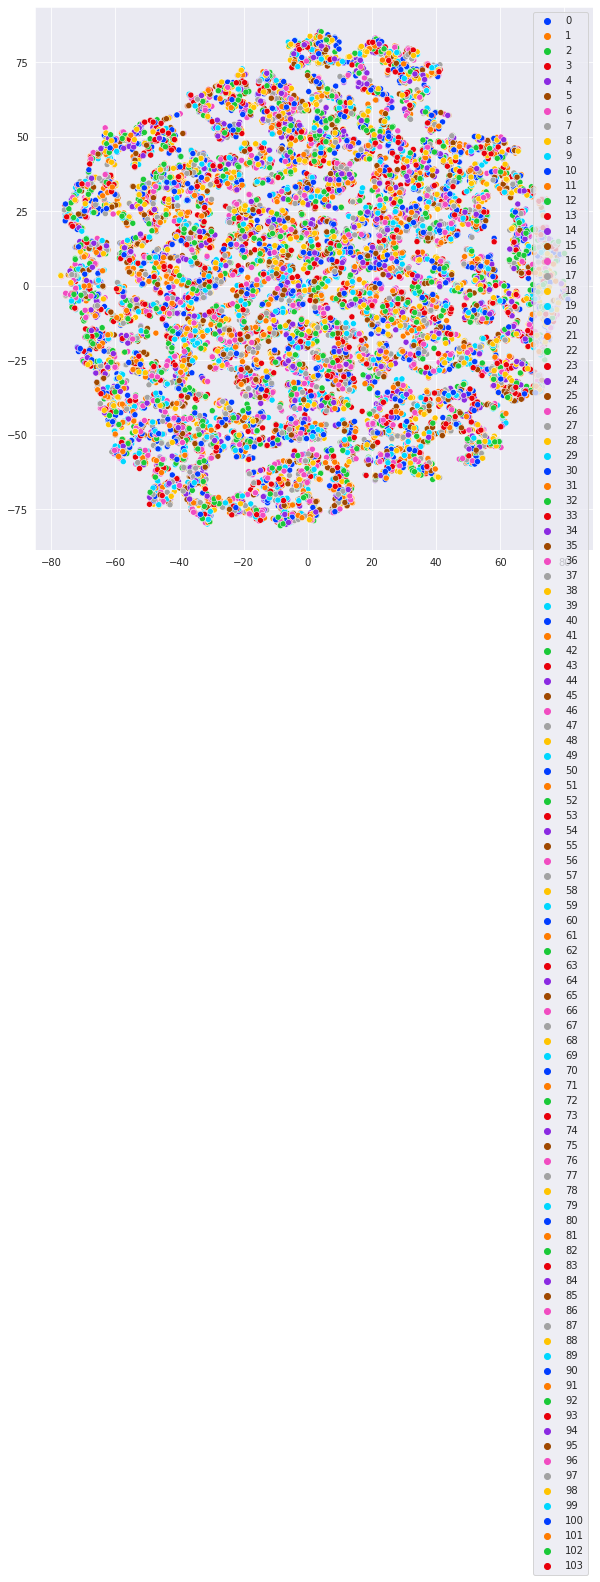

In [ ]:
fig = plot_vecs_n_labels(low_vectors, y_train_enc)

In [ ]:
print(len(low_vectors))

18804


In [ ]:
print(len(np.unique(labels)))

104
